In [2]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load a sample dataset
nse = pd.read_csv('/home/jothammasila/Projects/Datasets/nse.csv')

In [4]:
columns_drop = ['Change','Change%','Code','Name','Volume','Adjusted Price']
nse = nse.drop(columns_drop, axis=1)
nse.head()

,Date,12m Low,12m High,Day Low,Day High,Day Price,Previous
0,3-Jan-22,10,15,13.5,13.8,13.5,13.5
1,3-Jan-22,355,427,385,385,385,385
2,3-Jan-22,80,101,99.5,99.5,99.5,95.5
3,3-Jan-22,260,360,320,320,320,320
4,3-Jan-22,16.75,22.6,18.7,18.7,18.7,18.7


In [5]:
nse = nse.dropna()
nse

,Date,12m Low,12m High,Day Low,Day High,Day Price,Previous
0,3-Jan-22,10,15,13.5,13.8,13.5,13.5
1,3-Jan-22,355,427,385,385,385,385
2,3-Jan-22,80,101,99.5,99.5,99.5,95.5
3,3-Jan-22,260,360,320,320,320,320
4,3-Jan-22,16.75,22.6,18.7,18.7,18.7,18.7
...,...,...,...,...,...,...,...
6727,31-May-22,0.27,0.27,0.27,0.27,0.27,0.27
6728,31-May-22,26.1,36.4,29,29,29,30
6729,31-May-22,25.5,45.25,25.95,26.45,26,26.25
6730,31-May-22,5,7.48,5.5,5.6,5.56,5.58


In [6]:
# Change the Date column to datetime dtype
nse['Date'] = pd.to_datetime(nse['Date'])
print(type(nse['Date'].values.dtype))

<class 'numpy.dtype[datetime64]'>


/tmp/ipykernel_15369/876926369.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nse['Date'] = pd.to_datetime(nse['Date'])


In [7]:
columns_to_float = ['12m Low',	'12m High',	'Day Low',	'Day High',	'Day Price', 'Previous']
# convert to type float
# Convert each value in the specified columns to float
nse[columns_to_float] = nse[columns_to_float].apply(lambda x: pd.to_numeric(x, errors='coerce'))


In [8]:
X = nse[['12m Low', '12m High', 'Day Low', 'Day High', 'Previous']]
y = nse['Day Price']

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_test = X_test.dropna()
y_test = y_test[~np.isnan(y_test)]

In [11]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [12]:
# Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',  # RMean Squared Error
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

# Train the model without early stopping
num_round = 100
bst = lgb.train(params, train_data, num_boost_round=num_round)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 964
[LightGBM] [Info] Number of data points in the train set: 5385, number of used features: 5
[LightGBM] [Info] Start training from score 44.186182


In [13]:
# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

In [14]:
# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error on Test Set: {rmse}')

Root Mean Squared Error on Test Set: 0.9052310770174201


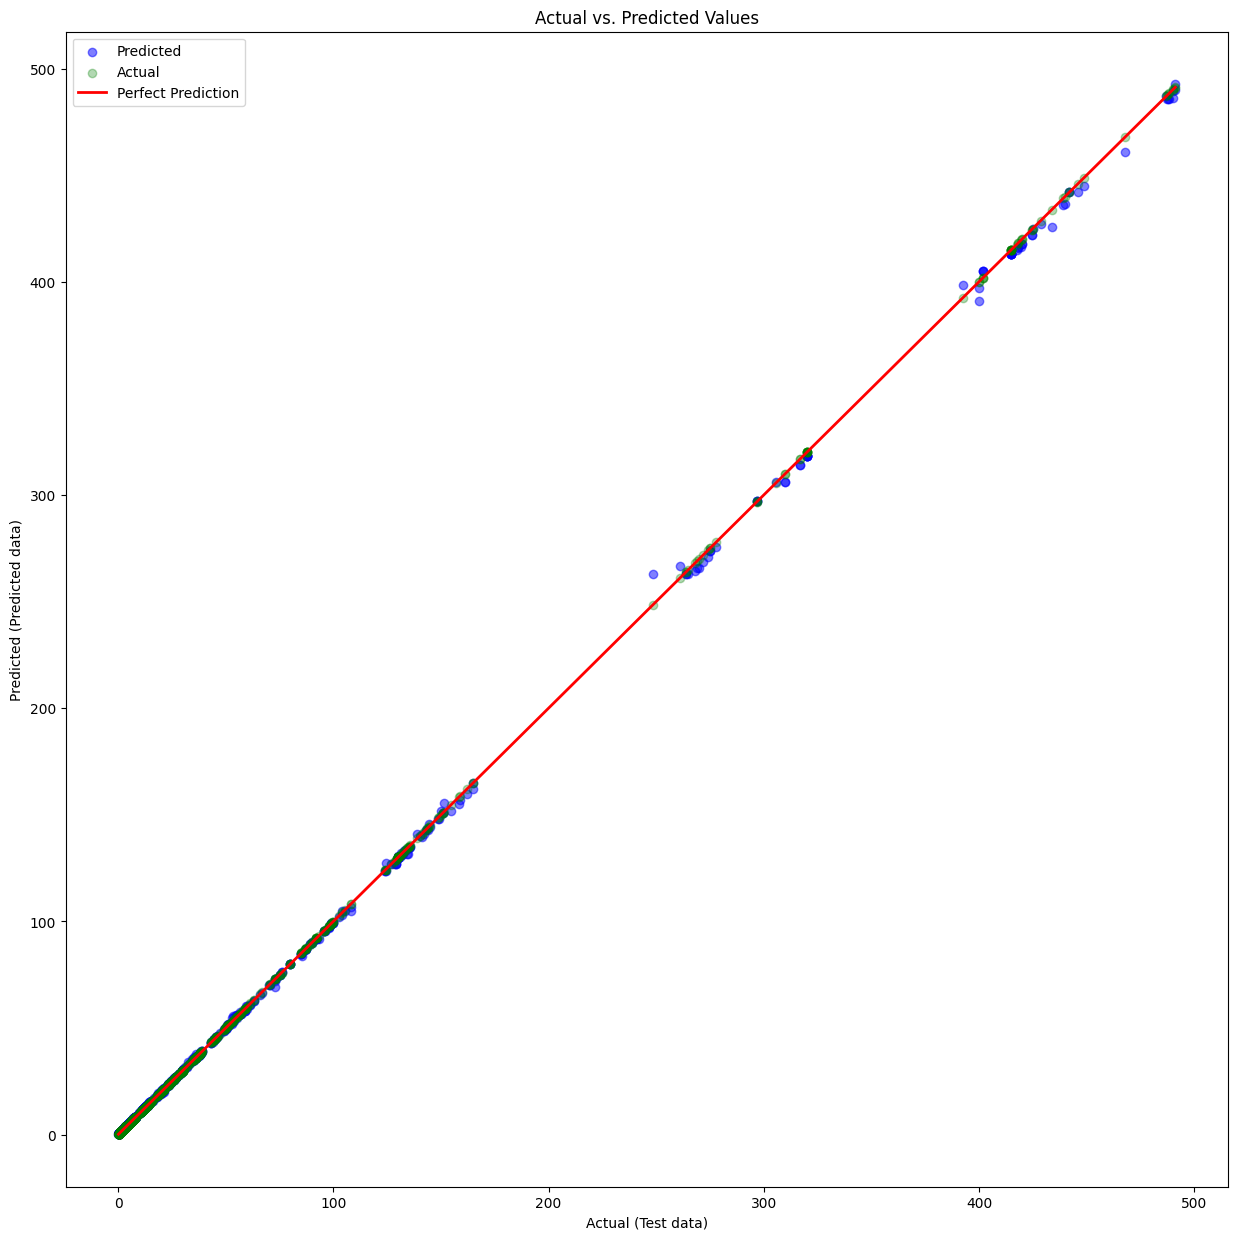

In [15]:
# Plotting actual vs. predicted values with legend
plt.figure(figsize=(15,15))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted')
plt.scatter(y_test, y_test, color='green', alpha=0.3, label='Actual') 
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual (Test data)')
plt.ylabel('Predicted (Predicted data)')
plt.title('Actual vs. Predicted Values')
plt.legend(loc='upper left')  # Position the legend 
plt.show()
